In [1]:
%load_ext autoreload
%autoreload 2

from readers import *
from datalib import *
from filters import *
import config.config_jump_detection as config
import matplotlib.pyplot as plt
import time as t
%matplotlib notebook

script_starting_time = t.time()

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
start_time = t.time()
print("Reading demonstration data")

force_ext = []
force_ext_vec = []
position_data = []
velocity_data = []
tau_ext_data = []

starting_indices = []
ending_indices = []

for i in range(len(config.demos)):
    demo = config.demos[i]
    print(f'Reading demonstration file {demo}')

    force_ext.append(DataSet())
    force_ext_vec.append(PositionDataSet())
    position_data.append(PositionDataSet())
    velocity_data.append(PositionDataSet())
    tau_ext_data.append(DataSet())

    # Read data
    franka_reader = FrankaStateReader(demo)
    starting_position = None
    starting_force = None
    ending_position = franka_reader.last_datapoint().value.position
    ending_force = franka_reader.last_datapoint().value.force_external_magnitude
    starting_index = None
    ending_index = None
    
    while not franka_reader.end():
        dp = franka_reader.next_datapoint()
        time = dp.time
        franka_state = dp.value
        
        if starting_position is None:
            starting_position = franka_state.position
            starting_force = franka_state.force_external_magnitude
        elif starting_index is None:
            if franka_state.distance(starting_position) > 0.01 or np.linalg.norm(franka_state.velocity) > 0.01 or abs(franka_state.force_external_magnitude - starting_force) > 0.3:
                starting_index = len(force_ext[i])
        elif ending_index is None:
            if franka_state.distance(ending_position) < 0.01 and np.linalg.norm(franka_state.velocity) < 0.01 and abs(franka_state.force_external_magnitude - ending_force) < 0.3:
                ending_index = len(force_ext[i]) + 1

        force_ext[i].append(DataPoint(time, franka_state.force_external_magnitude))
        force_ext_vec[i].append(PositionDataPoint(time, franka_state.force_external))
        position_data[i].append(PositionDataPoint(time, franka_state.position))
        velocity_data[i].append(PositionDataPoint(time, franka_state.velocity))
        tau_ext_data[i].append(DataPoint(time, franka_state.tau_external))

    if ending_index is None:
        ending_index = -1
    else:
        ending_index = min(len(force_ext[i]) - 1, ending_index+30)
    
    starting_indices.append(starting_index)
    ending_indices.append(ending_index)
        
    # Align time
    force_ext[i].align_time()
    force_ext_vec[i].align_time()
    position_data[i].align_time()
    velocity_data[i].align_time()
    tau_ext_data[i].align_time()
    
    print(f'Average sampling frequency of {config.demos[i]} is {(len(force_ext[i]) - 1) / (force_ext[i].time[-1] - force_ext[i].time[0])} Hz')

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Reading demonstration data
Reading demonstration file data/demo8.bag
Average sampling frequency of data/demo8.bag is 972.195491622322 Hz
Reading demonstration file data/demo9.bag
Average sampling frequency of data/demo9.bag is 964.7218242164415 Hz
Reading demonstration file data/demo10.bag
Average sampling frequency of data/demo10.bag is 965.1457187604717 Hz
--- 61.13802218437195 seconds ---
Done


In [79]:
start_time = t.time()
print("Detecting jumps")

predictions_data = []
bounds_data = []
jump_indices_data = []
impact_indices_data = []

for i in range(len(config.demos)):
    predictions_data.append(DataSet())
    bounds_data.append(DataSet())
    jump_indices_data.append([])
    impact_indices_data.append([])

jump_detector = config.jump_detector.copy()

for i in range(len(config.demos)):
    
    data = force_ext[i]
    
    # Detect jumps
    jump_detector.reset()
    starting_index = starting_indices[i]
    ending_index = ending_indices[i]
    for j in range(len(data[starting_index:ending_index])):
        jump_detected, info = jump_detector.update(data[j+starting_index])
        if jump_detected:
            impact_indices_data[i].append(j+starting_index)
        if info[5]:
            jump_indices_data[i].append(j+starting_index)
        predictions_data[i].append(info[0])
        bounds_data[i].append(info[1])
        
print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Detecting jumps
--- 3.7280168533325195 seconds ---
Done


<IPython.core.display.Javascript object>


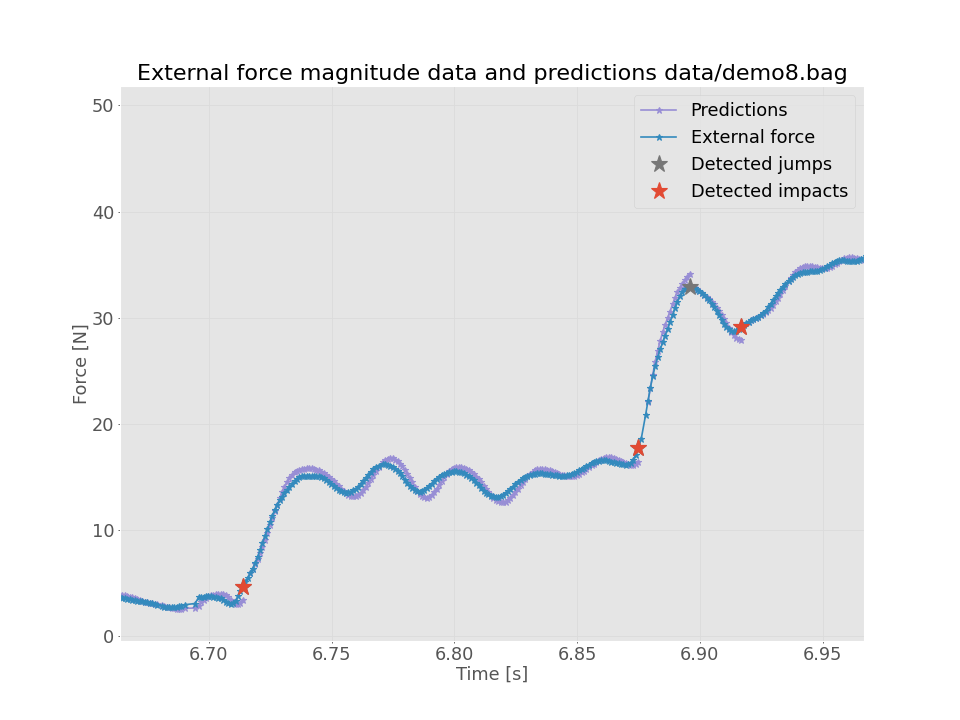

<IPython.core.display.Javascript object>


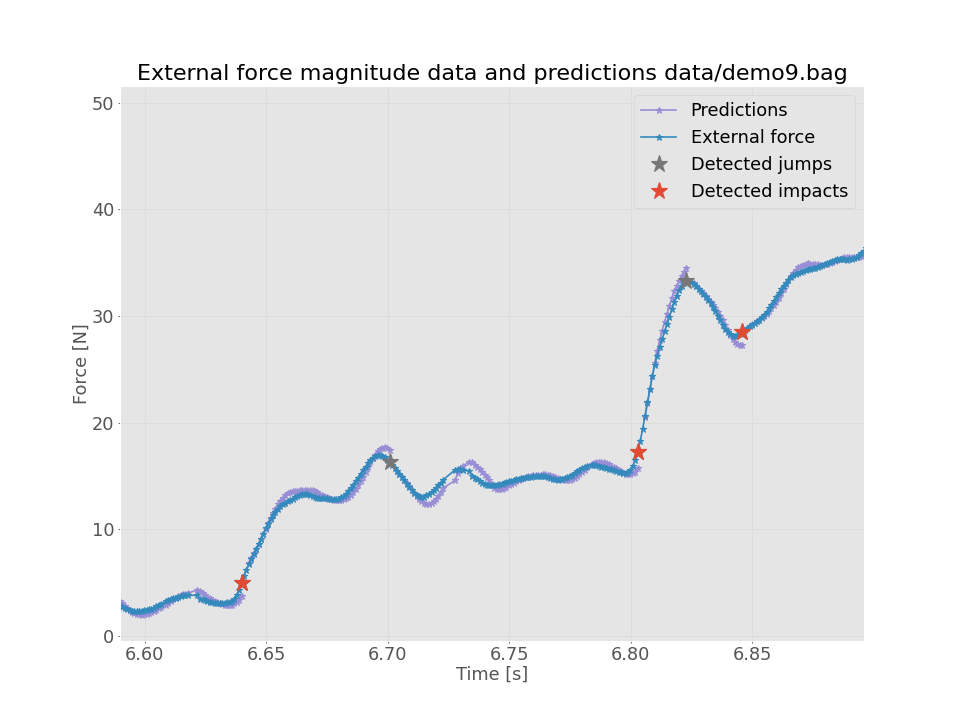

/home/sven/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


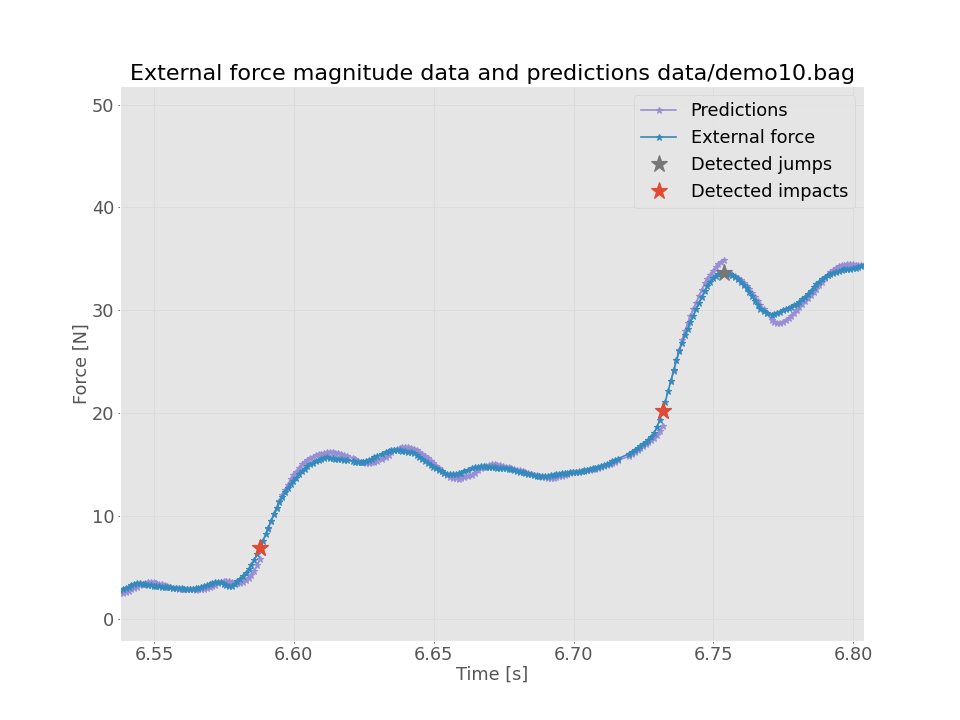

In [80]:
# Plotting external force data

for i in range(len(config.demos)):
    demo = config.demos[i]
    data = force_ext[i]
    
    ## Plot external force
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Predictions
    plt.plot(predictions_data[i].time, predictions_data[i].value, 'C2-*', linewidth=config.linewidth, markersize=config.markersize2, label='Predictions')

    # External force data
    plt.plot(data.time, data.value, 'C1-*', linewidth=config.linewidth, markersize=config.markersize2, label='External force')

    # Jumps and impacts
    force_ext_jumps = data[jump_indices_data[i]]
    plt.plot(force_ext_jumps.time, force_ext_jumps.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected jumps')
    force_ext_impacts = data[impact_indices_data[i]]
    plt.plot(force_ext_impacts.time, force_ext_impacts.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected impacts')
    
    # Adding title and labels
    plt.title('External force magnitude data and predictions ' + demo,fontsize=config.fontsize1)
#     plt.title('External force magnitude data ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Force [N]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
    if config.xlim is not None and len(jump_indices_data[i]) > 0:
        x_min = force_ext[i][min(jump_indices_data[i])].time + config.xlim[0]
        x_max = force_ext[i][max(jump_indices_data[i])].time + config.xlim[-1]
        plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()

if config.show_figs:
    plt.show()

<IPython.core.display.Javascript object>


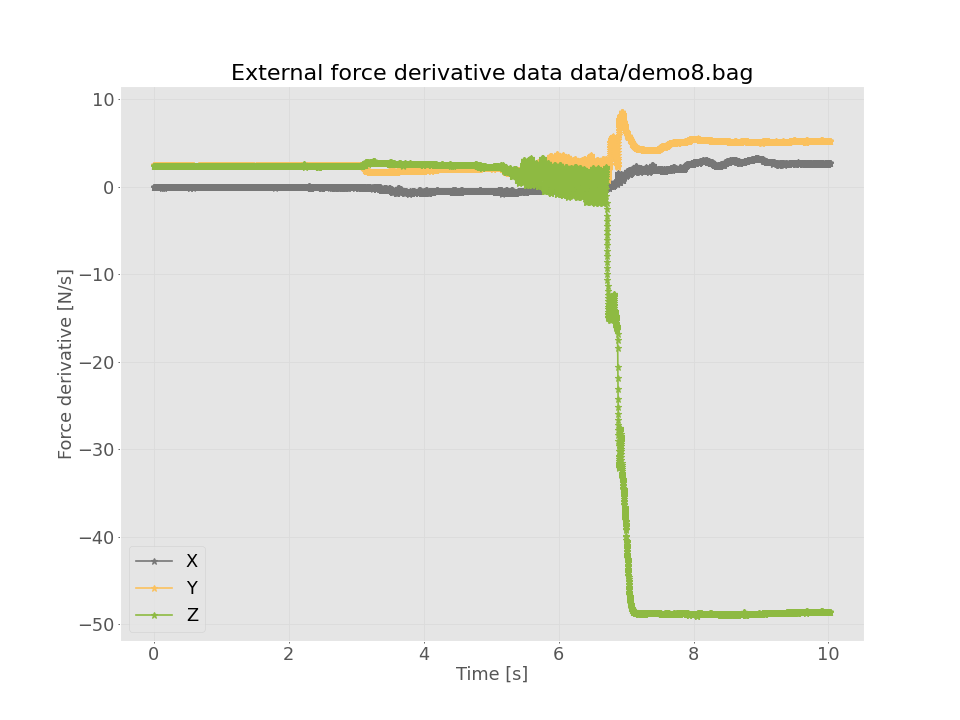

<IPython.core.display.Javascript object>


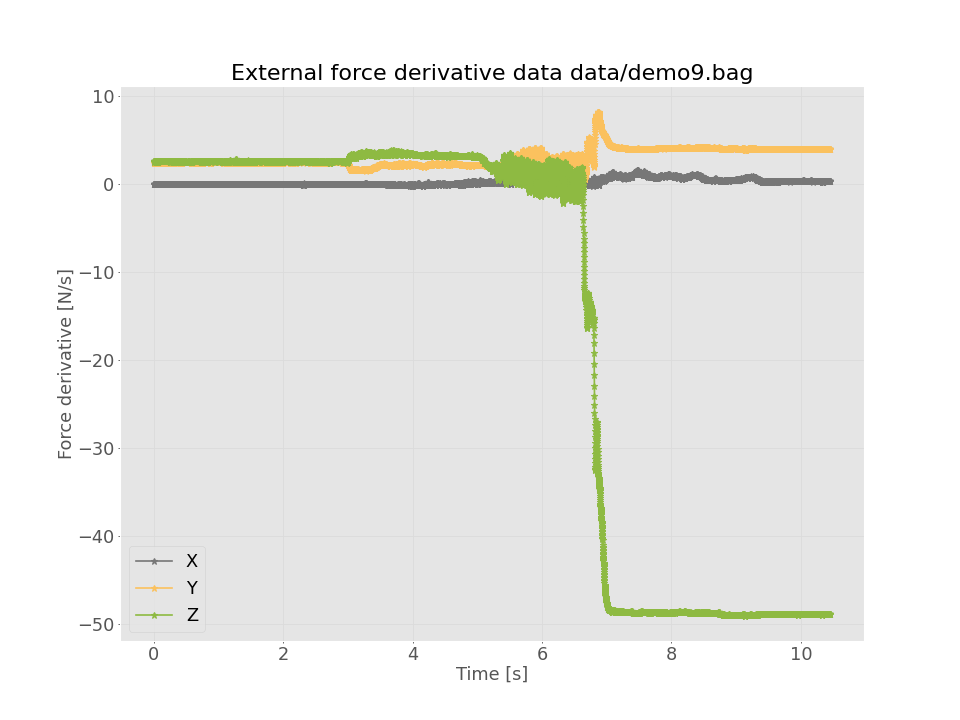

/home/sven/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


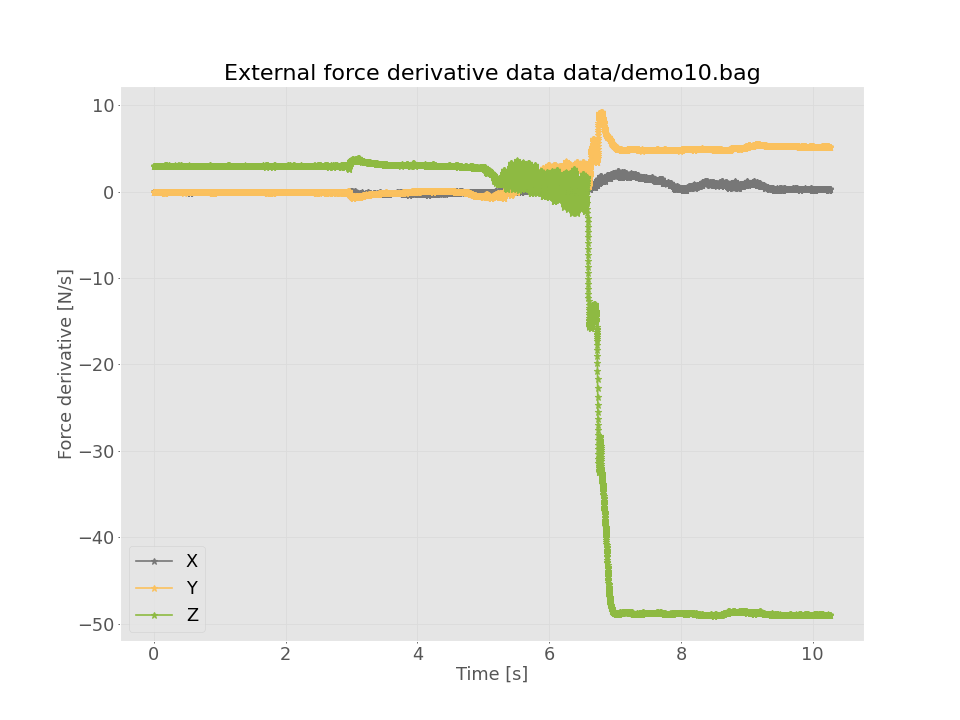

In [82]:
# Plotting derivative external force data

for i in range(len(config.demos)):
    demo = config.demos[i]
    data = force_ext_vec[i].diff
    
    ## Plot external force
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

#     # Predictions
#     plt.plot(predictions_data[i].time, predictions_data[i].value, 'C2-*', linewidth=config.linewidth, markersize=config.markersize2, label='Predictions')

    # External force data
    for j in range(3):
        plt.plot(data.time, data.get_index(j).value, f'C{j+3}-*', linewidth=config.linewidth, markersize=config.markersize2, label=config.labels[j])

#     # Jumps and impacts
#     force_ext_jumps = data[jump_indices_data[i]]
#     plt.plot(force_ext_jumps.time, force_ext_jumps.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected jumps')
#     force_ext_impacts = data[impact_indices_data[i]]
#     plt.plot(force_ext_impacts.time, force_ext_impacts.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected impacts')
    
    # Adding title and labels
    plt.title('External force derivative data ' + demo,fontsize=config.fontsize1)
#     plt.title('External force magnitude data ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Force derivative [N/s]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
#     if config.xlim is not None and len(jump_indices_data[i]) > 0:
#         x_min = force_ext[i][min(jump_indices_data[i])].time + config.xlim[0]
#         x_max = force_ext[i][max(jump_indices_data[i])].time + config.xlim[-1]
#         plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()

if config.show_figs:
    plt.show()

<IPython.core.display.Javascript object>


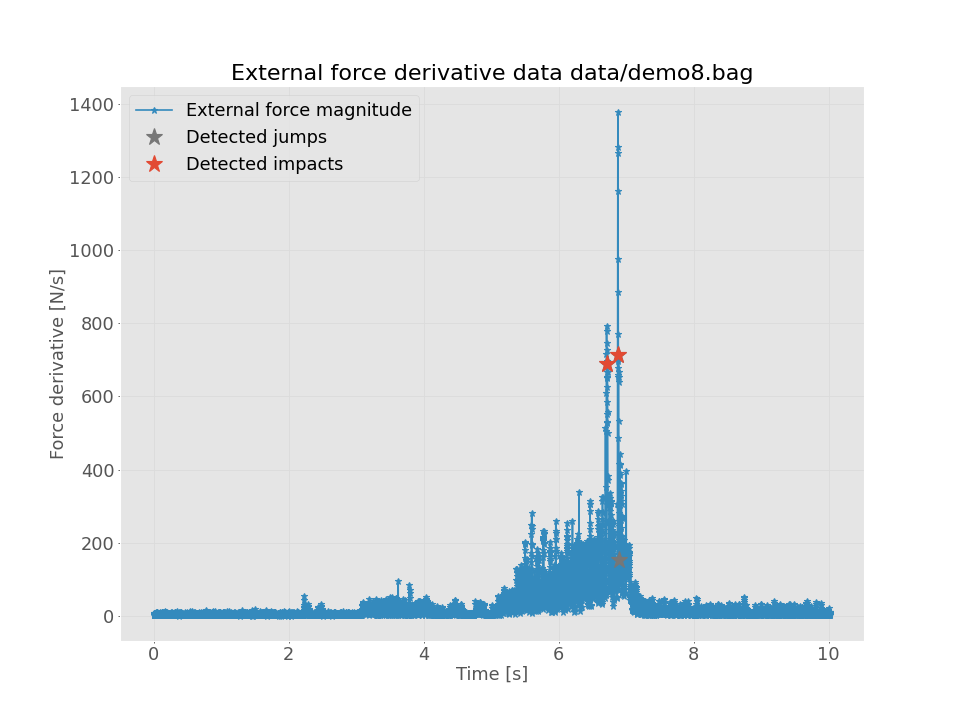

<IPython.core.display.Javascript object>


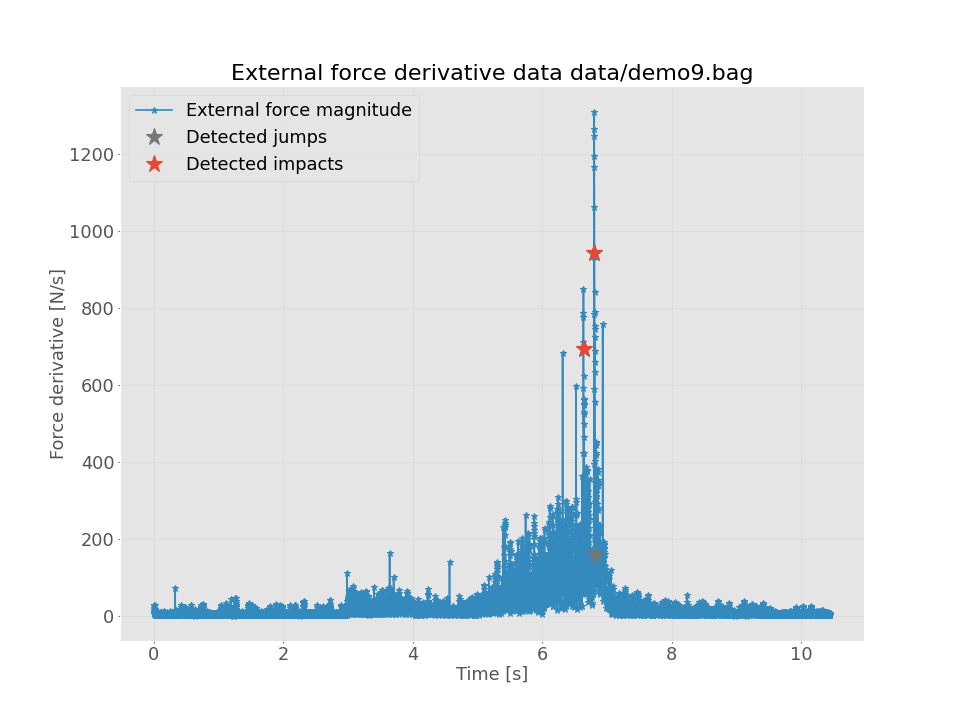

/home/sven/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


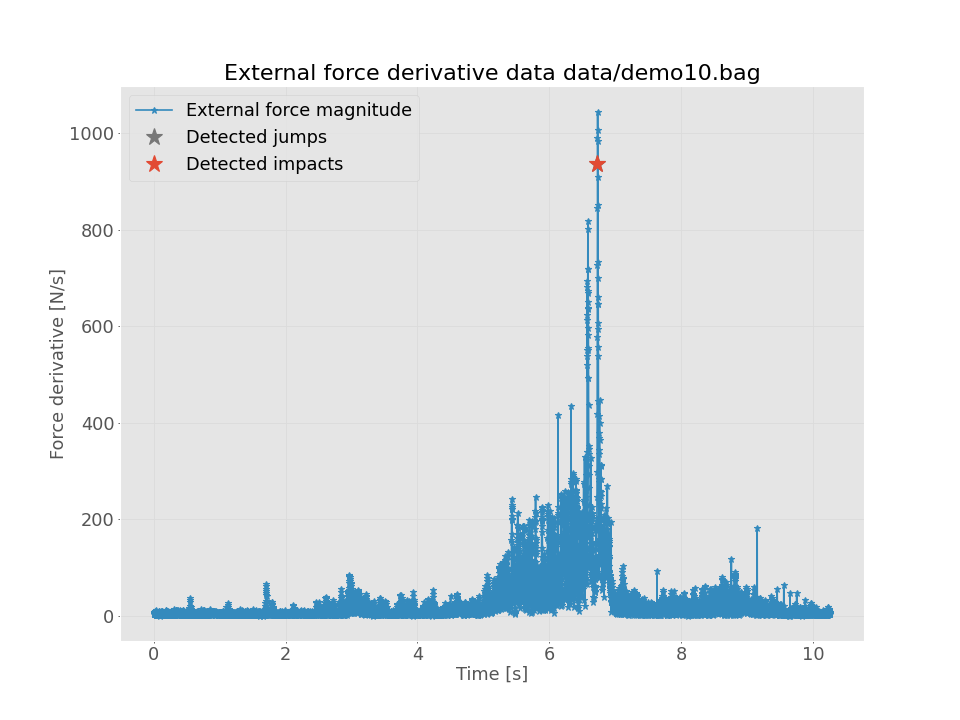

In [32]:
# Plotting derivative external force data

for i in range(len(config.demos)):
    demo = config.demos[i]
    data = force_ext_vec[i].diff.mag
    
    ## Plot external force
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

#     # Predictions
#     plt.plot(predictions_data[i].time, predictions_data[i].value, 'C2-*', linewidth=config.linewidth, markersize=config.markersize2, label='Predictions')

    # External force data
    plt.plot(data.time, data.value, f'C1-*', linewidth=config.linewidth, markersize=config.markersize2, label='External force magnitude')

    # Jumps and impacts
    force_ext_jumps = data[jump_indices_data[i]]
    plt.plot(force_ext_jumps.time, force_ext_jumps.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected jumps')
    force_ext_impacts = data[impact_indices_data[i]]
    plt.plot(force_ext_impacts.time, force_ext_impacts.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected impacts')
    
    # Adding title and labels
    plt.title('External force derivative data ' + demo,fontsize=config.fontsize1)
#     plt.title('External force magnitude data ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Force derivative [N/s]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
#     if config.xlim is not None and len(jump_indices_data[i]) > 0:
#         x_min = force_ext[i][min(jump_indices_data[i])].time + config.xlim[0]
#         x_max = force_ext[i][max(jump_indices_data[i])].time + config.xlim[-1]
#         plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()

if config.show_figs:
    plt.show()

<IPython.core.display.Javascript object>


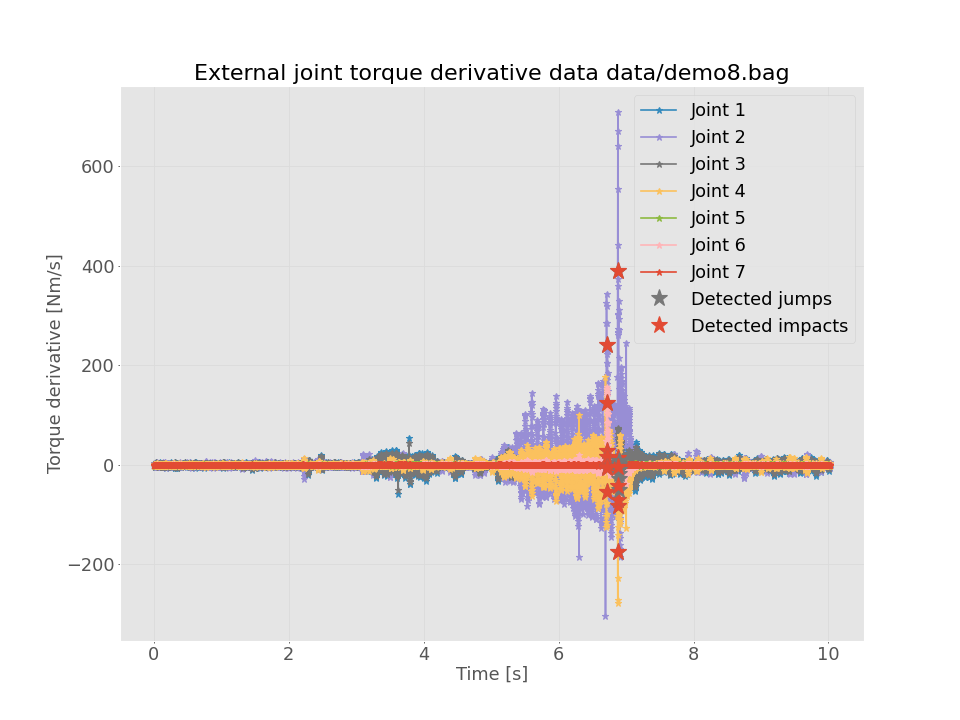

<IPython.core.display.Javascript object>


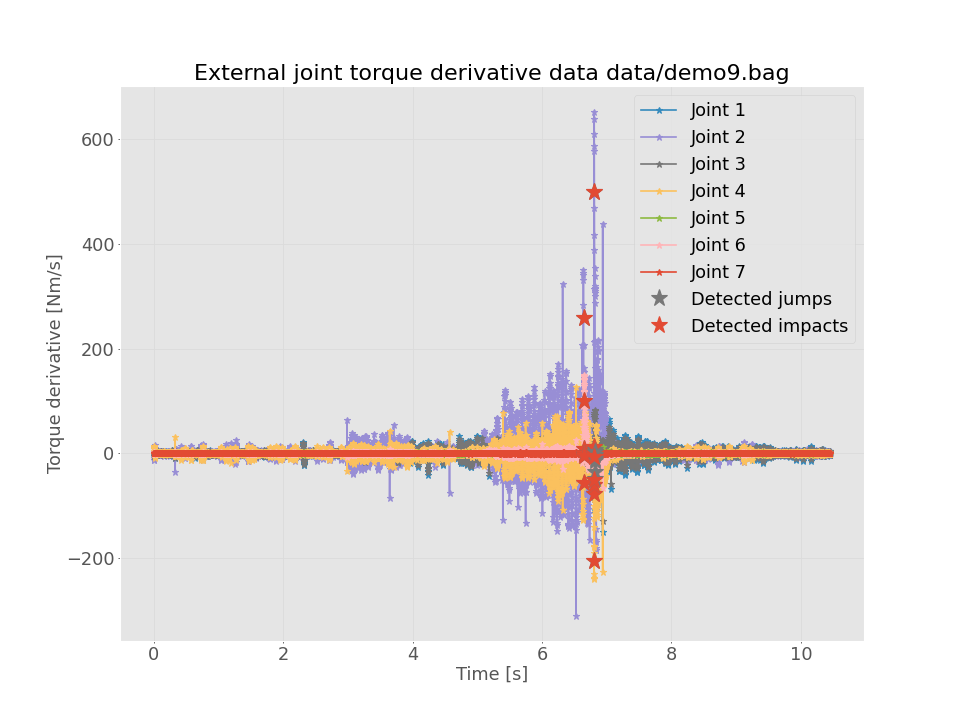

/home/sven/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


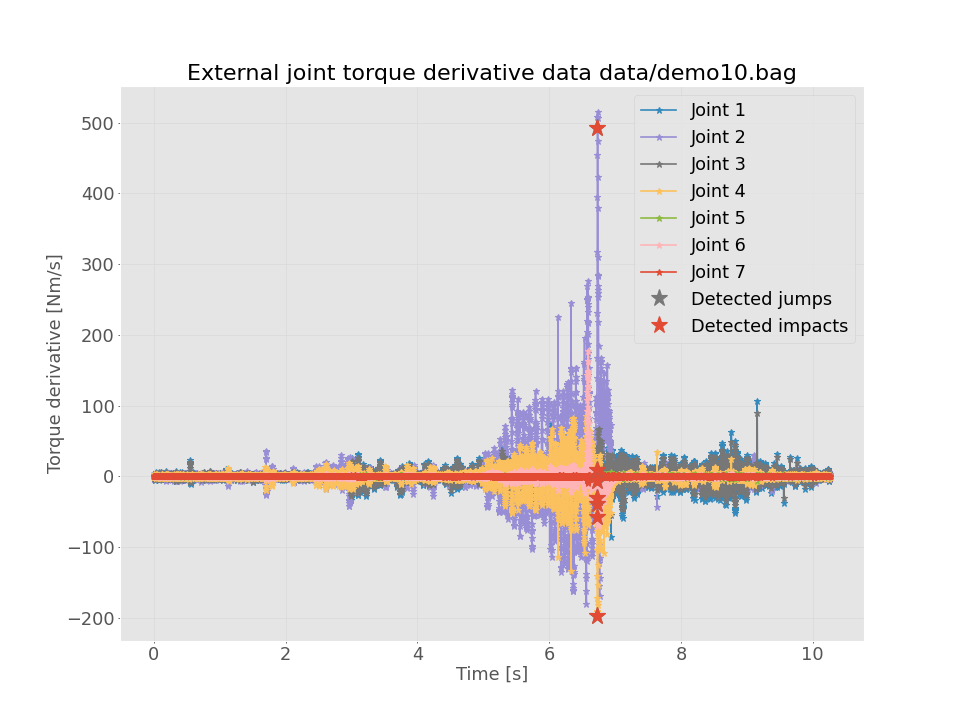

In [33]:
# Plotting derivative external force data

for i in range(len(config.demos)):
    demo = config.demos[i]
    data = tau_ext_data[i].diff
    
    ## Plot external force
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

#     # Predictions
#     plt.plot(predictions_data[i].time, predictions_data[i].value, 'C2-*', linewidth=config.linewidth, markersize=config.markersize2, label='Predictions')

    # External force data
    for j in range(7):
        plt.plot(data.time, data.get_index(j).value, f'C{j+1}-*', linewidth=config.linewidth, markersize=config.markersize2, label=f'Joint {j+1}')

    # Jumps and impacts
    for j in range(7):
        force_ext_jumps = data.get_index(j)[jump_indices_data[i]]
        plt.plot(force_ext_jumps.time, force_ext_jumps.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected jumps')
        force_ext_impacts = data.get_index(j)[impact_indices_data[i]]
        plt.plot(force_ext_impacts.time, force_ext_impacts.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected impacts')
    
    # Adding title and labels
    plt.title('External joint torque derivative data ' + demo,fontsize=config.fontsize1)
#     plt.title('External force magnitude data ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Torque derivative [Nm/s]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
#     if config.xlim is not None and len(jump_indices_data[i]) > 0:
#         x_min = force_ext[i][min(jump_indices_data[i])].time + config.xlim[0]
#         x_max = force_ext[i][max(jump_indices_data[i])].time + config.xlim[-1]
#         plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()

if config.show_figs:
    plt.show()

<IPython.core.display.Javascript object>


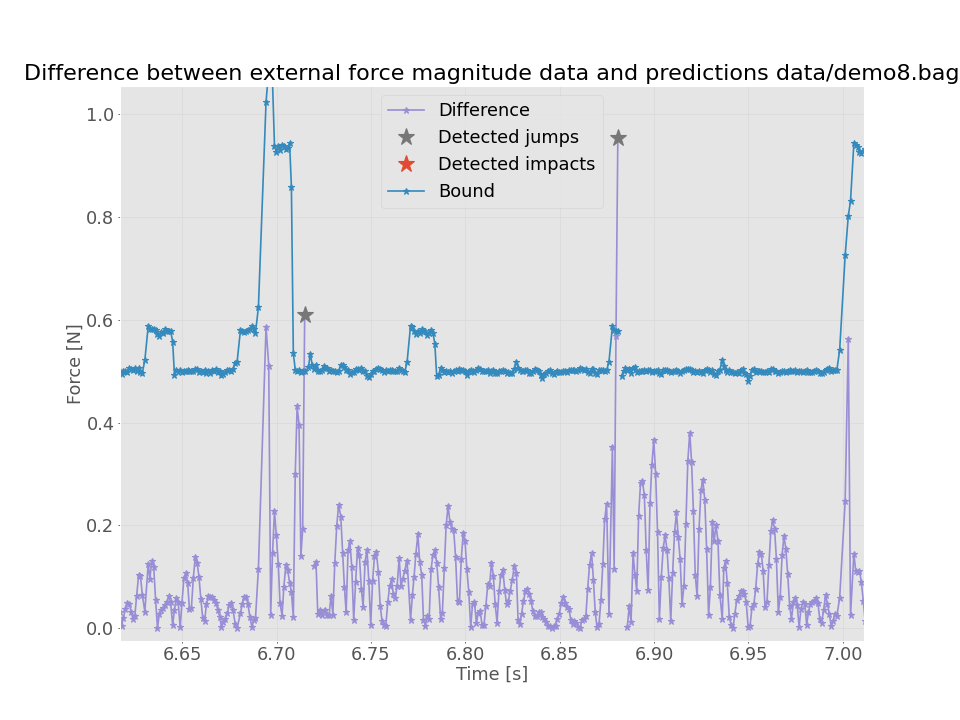

<IPython.core.display.Javascript object>


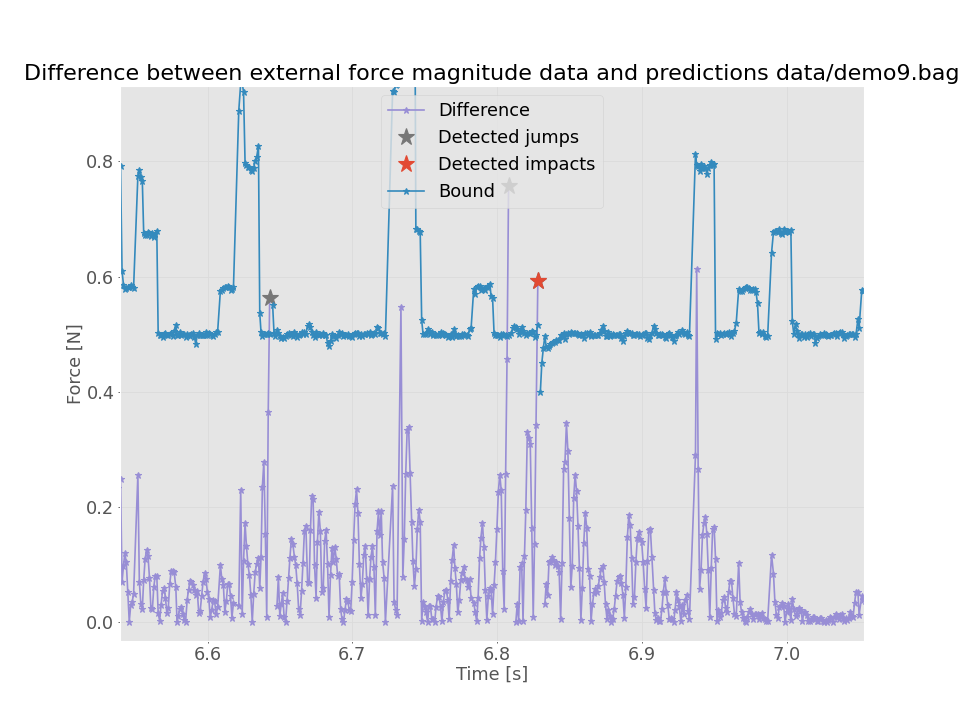

/home/sven/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


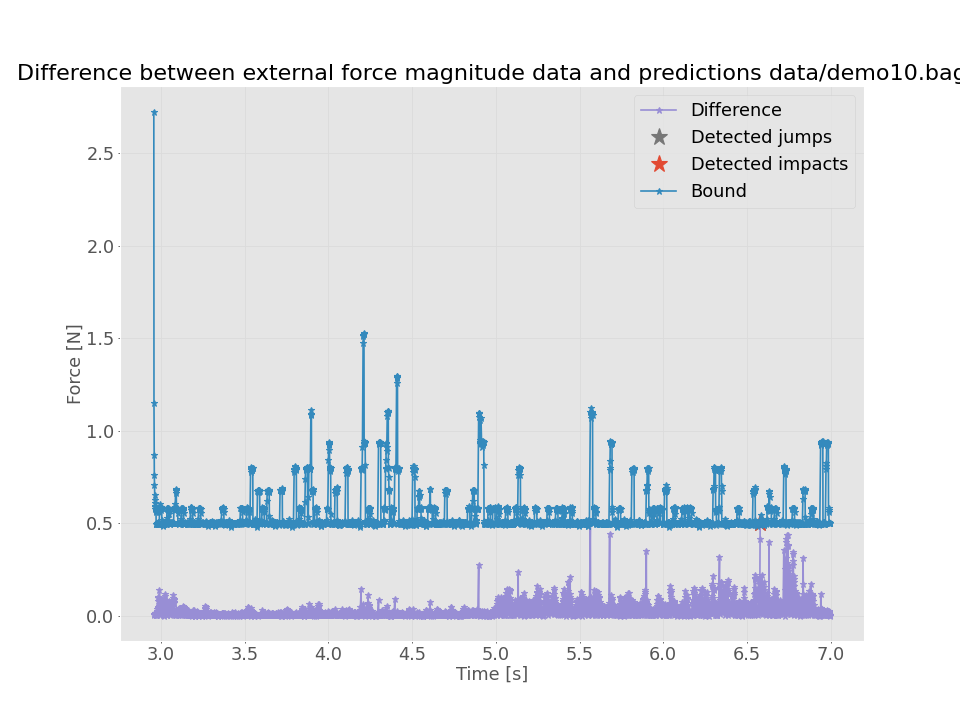

In [76]:
# Plot difference between data and prediction

for i in range(len(config.demos)):
    demo = config.demos[i]
    data = force_ext[i]
    starting_index = starting_indices[i]
    ending_index = ending_indices[i]
    pred_diff = abs(data[starting_index:ending_index] - predictions_data[i])
    
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Difference between data and prediction
    plt.plot(pred_diff.time, pred_diff.value, 'C2-*', linewidth=config.linewidth, markersize=config.markersize2, label='Difference')
    pred_diff_jumps = pred_diff[[index - starting_index for index in jump_indices_data[i]]]
    plt.plot(pred_diff_jumps.time, pred_diff_jumps.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1,label='Detected jumps')
    pred_diff_impacts = pred_diff[[index - starting_index for index in impact_indices_data[i]]]
    plt.plot(pred_diff_impacts.time, pred_diff_impacts.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1,label='Detected impacts')
    
    # Bound
    plt.plot(bounds_data[i].time, bounds_data[i].value, 'C1-*', linewidth=config.linewidth, markersize=config.markersize2, label='Bound')
    
    # Adding title and labels
    plt.title('Difference between external force magnitude data and predictions ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Force [N]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
#     if config.xlim is not None and len(jump_indices_data[i]) > 0:
#         x_min = force_ext[i][min(jump_indices_data[i])].time + config.xlim[0]
#         x_max = force_ext[i][max(jump_indices_data[i])].time + config.xlim[-1]
#         plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()
        
if config.show_figs:
    plt.show()

<IPython.core.display.Javascript object>


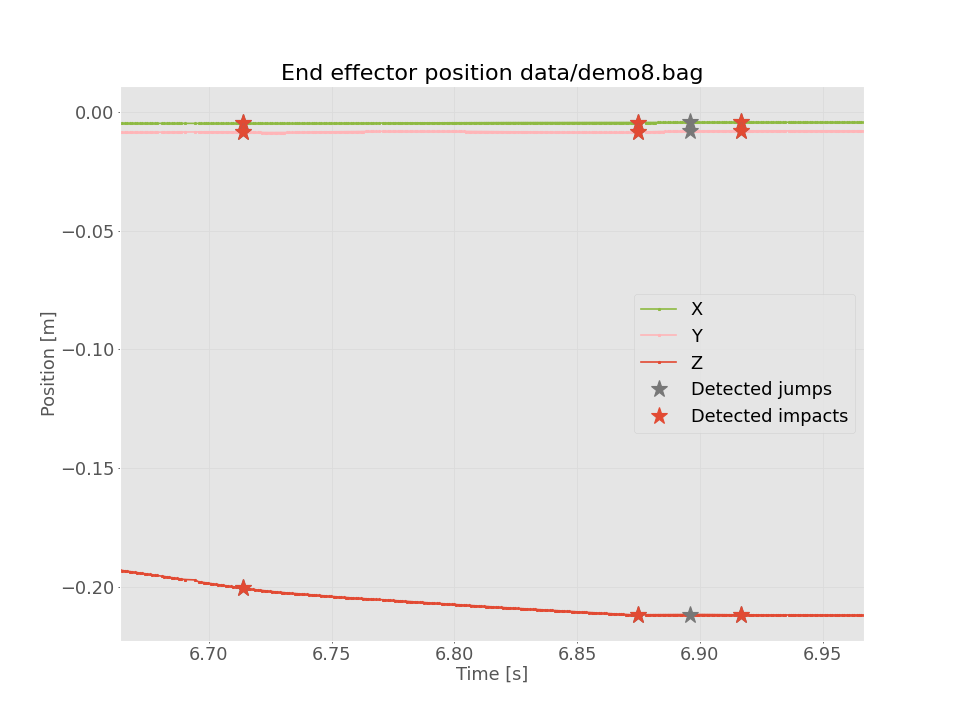

<IPython.core.display.Javascript object>


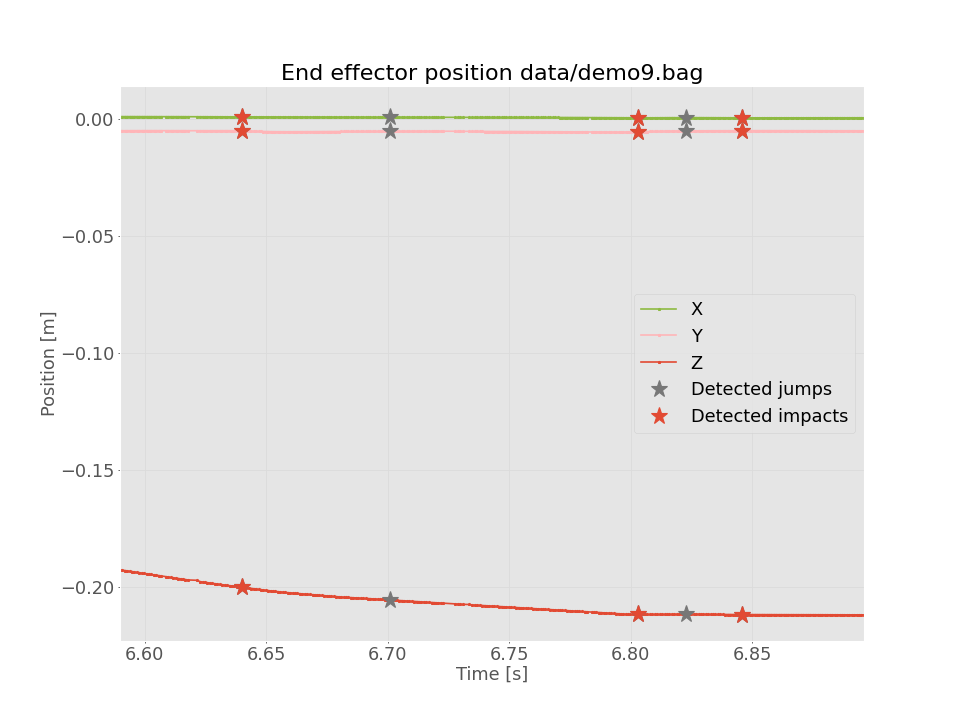

<IPython.core.display.Javascript object>


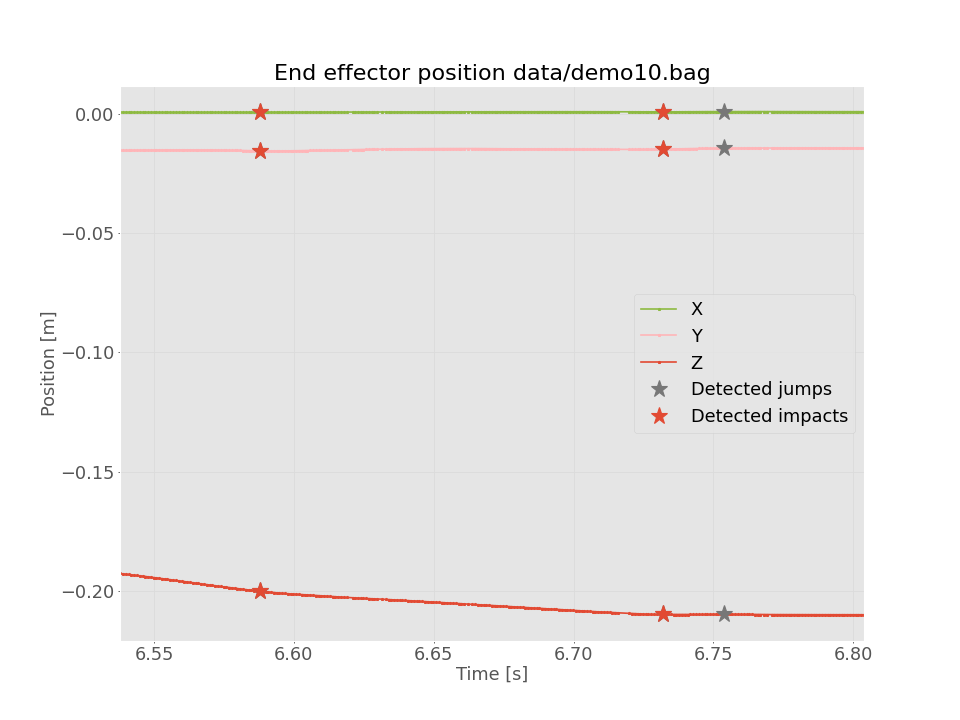

In [9]:
# Plot position data

for i in range(len(config.demos)):
    
    demo = config.demos[i]

    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Position
    for j in range(3):
        plt.plot(position_data[i].time, (position_data[i].get_index(j)-position_data[i].get_index(j)[0]).value, 'C' + str(j+5) + '-*', linewidth=config.linewidth, markersize=config.markersize3, label=config.labels[j])
        
    for j in range(3):
        position_jumps = position_data[i].get_index(j)[jump_indices_data[i]]
        plt.plot(position_jumps.time, (position_jumps-position_data[i].get_index(j)[0]).value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected jumps')
        position_impacts = position_data[i].get_index(j)[impact_indices_data[i]]
        plt.plot(position_impacts.time, (position_impacts-position_data[i].get_index(j)[0]).value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected impacts')
        
    # Adding title and labels
    plt.title('End effector position ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Position [m]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
    if config.xlim is not None and len(jump_indices_data[i]) > 0:
        x_min = force_ext[i][min(jump_indices_data[i])].time + config.xlim[0]
        x_max = force_ext[i][max(jump_indices_data[i])].time + config.xlim[-1]
        plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()
        
if config.show_figs:
    plt.show()

<IPython.core.display.Javascript object>


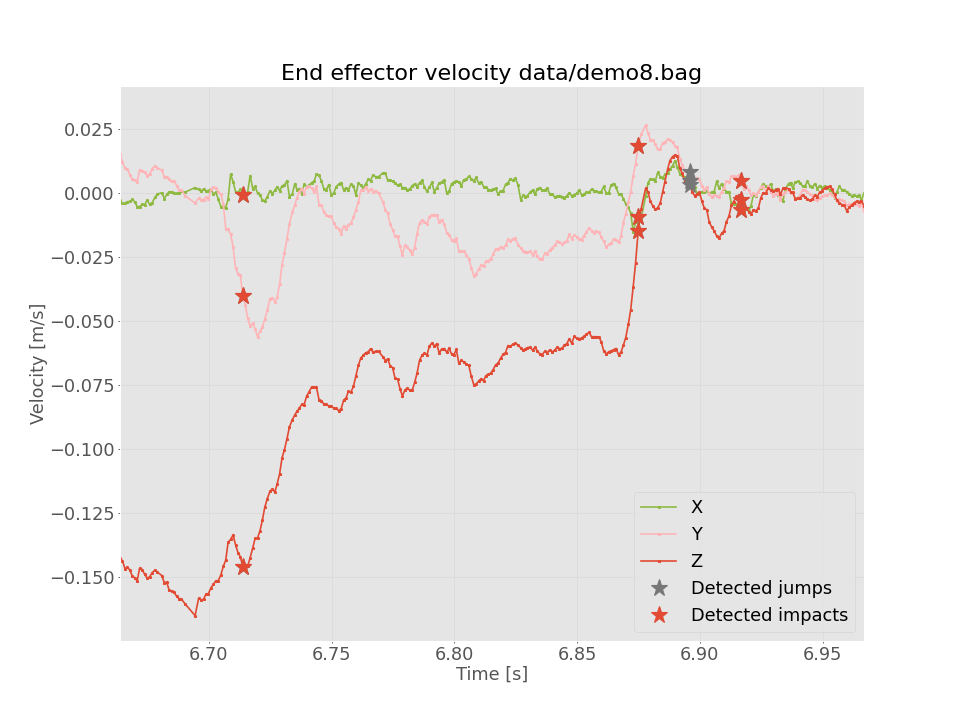

<IPython.core.display.Javascript object>


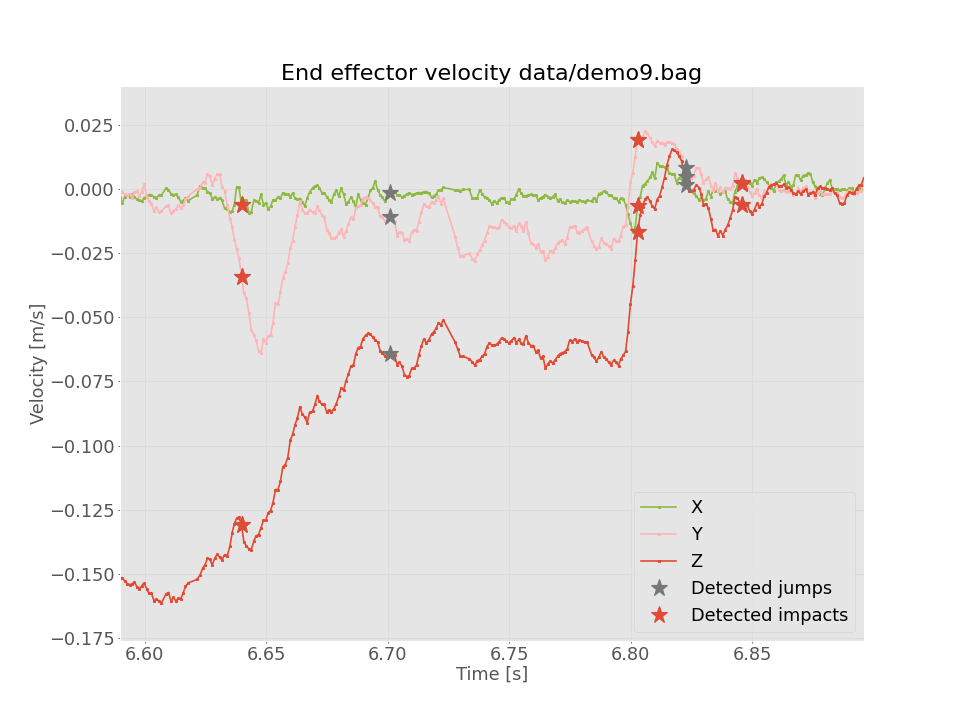

/home/sven/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<IPython.core.display.Javascript object>


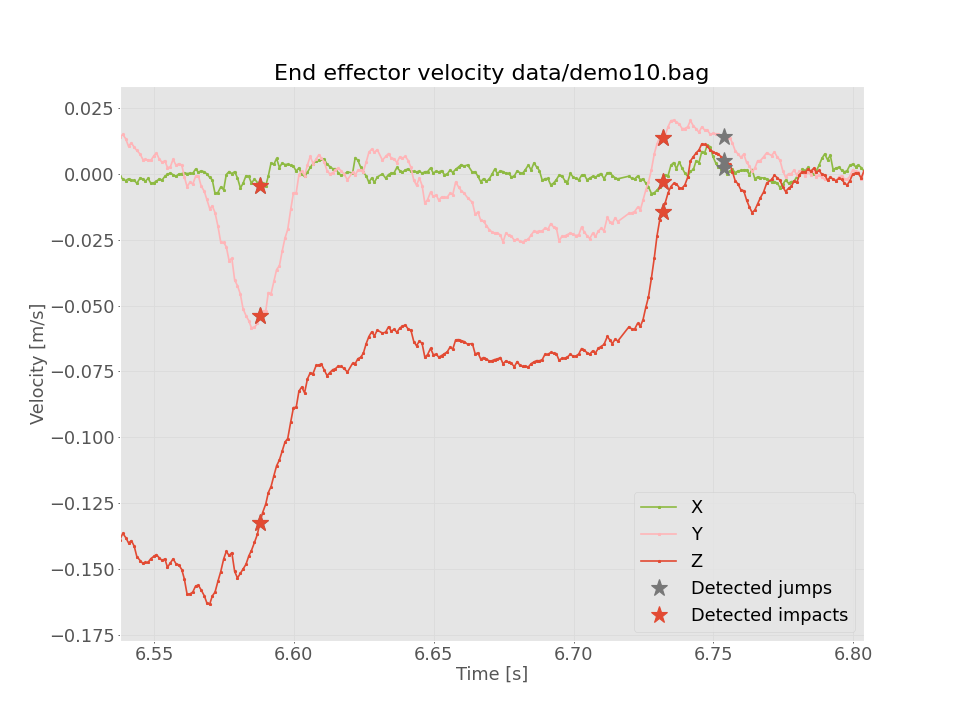

In [81]:
# Plot velocity data

for i in range(len(config.demos)):
    
    demo = config.demos[i]
    
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Velocity
    for j in range(3):
        plt.plot(velocity_data[i].time, velocity_data[i].get_index(j).value, 'C' + str(j+5) + '-*', linewidth=config.linewidth, markersize=config.markersize3, label=config.labels[j])
        
    for j in range(3):
        velocity_jumps = velocity_data[i].get_index(j)[jump_indices_data[i]]
        plt.plot(velocity_jumps.time, velocity_jumps.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected jumps')
        velocity_impacts = velocity_data[i].get_index(j)[impact_indices_data[i]]
        plt.plot(velocity_impacts.time, velocity_impacts.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected impacts')
        
    # Adding title and labels
    plt.title('End effector velocity ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Velocity [m/s]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
    if config.xlim is not None and len(jump_indices_data[i]) > 0:
        x_min = force_ext[i][min(jump_indices_data[i])].time + config.xlim[0]
        x_max = force_ext[i][max(jump_indices_data[i])].time + config.xlim[-1]
        plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()
        
if config.show_figs:
    plt.show()

In [11]:
# Print demos and impact indices

print('demos = [')
j = 0
for i in range(len(config.demos)):
    print(f'\t\'{config.demos[i]}\'',end='')
    if j < len(config.demos) - 1:
        print(',')
    else:
        print('')
    j += 1
print(']')

print('')

print('impact_intervals = [')
j = 0
for i in range(len(config.demos)):
    print('\t[(', end='')
    for index in impact_indices_data[i]:
        print(index, end=',')
    if j < len(config.demos) - 1:
        print(')],')
    else:
        print(')]')
    j += 1
print(']')

print('')

print('jump_intervals = [')
j = 0
for i in range(len(config.demos)):
    print('\t[(', end='')
    for index in jump_indices_data[i]:
        print(index, end=',')
    if j < len(config.demos) - 1:
        print(')],')
    else:
        print(')]')
    j += 1
print(']')

demos = [
	'data/demo8.bag',
	'data/demo9.bag',
	'data/demo10.bag'
]

impact_intervals = [
	[(6514,6674,6715,)],
	[(6388,6544,6587,)],
	[(6360,6498,)]
]

jump_intervals = [
	[(6514,6674,6694,6715,)],
	[(6388,6449,6544,6564,6587,)],
	[(6360,6498,6520,)]
]


In [12]:
start_time = t.time()
print("Finding detection delay")

real_impact_indices_data = []
detection_delays_data = []
detection_delays_indices_data = []

for i in range(len(config.demos)):
    real_impact_indices_data.append([])
    detection_delays_data.append([])
    detection_delays_indices_data.append([])

for i in range(len(config.demos)):
    
#     print(impact_indices_data[i])
    
    for k in range(2):
        start_compare = 0
        if k > 0:
            end = impact_indices_data[i][1]+1
            impact_index = impact_indices_data[i][1]
            start_compare = impact_indices_data[i][0] + 1
            for index in jump_indices_data[i]:
                if index + 1 > start_compare and index + 1 < impact_index:
                    start_compare = index + 1
        else:
            end = impact_indices_data[i][0]+1
        start = max(start_compare,round(end - (jump_detector.max_window_length + 1)))
        
        starting_index = starting_indices[i]
        ending_index = ending_indices[i]
        start -= starting_index
        end -= ending_index
        
        data = abs(force_ext[i][starting_index:ending_index][start:end] - predictions_data[i][start:end])
#         print(starting_index,ending_index,len(force_ext[i]),start,end)
#         if len(data) == 0:
#             continue
        impact_detection_time = data[-1].time
        real_impact_index = None
        
        for p in range(len(data) - 2):
            index = len(data) - p - 2
            if data[index].value is None:
                continue
            if data[index].value < data[index+1].value and (data[index-1].value is None or data[index].value < data[index-1].value):
                real_impact_index = start + index + starting_index
                break
        
        if real_impact_index is not None:
            detection_delays_data[i].append(impact_detection_time - data[real_impact_index - start - starting_index].time)
            detection_delays_indices_data[i].append(len(data) - 1 - (real_impact_index - start - starting_index))
        else:
            detection_delays_data[i].append(0)
            detection_delays_indices_data[i].append(0)
            real_impact_index = ending_index - 1
        real_impact_indices_data[i].append(real_impact_index)
    
    print(f'The detection delays for demonstration file {config.demos[i]} are {detection_delays_data[i]}')
    print(f'The detection delays in indices for demonstration file {config.demos[i]} are {detection_delays_indices_data[i]}')

for k in range(2):
    detection_delays = [i[k] for i in detection_delays_data if len(i) > 0]
    detection_delays_indices = [i[k] for i in detection_delays_indices_data if len(i) > 0]
    print(f'Maximal detection delay for {k+1}st impact is {max(detection_delays)}, average_detection_delay is {np.mean(detection_delays)}')
    print(f'Maximal detection delay in indices for {k+1}st impact is {max(detection_delays_indices)}, average_detection_delay is {np.mean(detection_delays_indices)}, median is {int(np.median(detection_delays_indices))}')

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Finding detection delay
The detection delays for demonstration file data/demo8.bag are [0.003936052322387695, 0.004006385803222656]
The detection delays in indices for demonstration file data/demo8.bag are [4, 4]
The detection delays for demonstration file data/demo9.bag are [0.009044647216796875, 0.005978584289550781]
The detection delays in indices for demonstration file data/demo9.bag are [9, 6]
The detection delays for demonstration file data/demo10.bag are [0.00900125503540039, 0.005984067916870117]
The detection delays in indices for demonstration file data/demo10.bag are [9, 6]
Maximal detection delay for 1st impact is 0.009044647216796875, average_detection_delay is 0.00732731819152832
Maximal detection delay in indices for 1st impact is 9, average_detection_delay is 7.333333333333333, median is 9
Maximal detection delay for 2st impact is 0.005984067916870117, average_detection_delay is 0.005323012669881185
Maximal detection delay in indices for 2st impact is 6, average_detecti

In [13]:
print('impact_detection_delays = [')
j = 0
for i in range(len(config.demos)):
    if len(detection_delays_indices_data[i]) == 0:
        continue
    print('\t[', end='')
    k = 0
    for delay in detection_delays_indices_data[i]:
        print(delay,end='')
        if k < len(detection_delays_indices_data[i]) - 1:
            print(',',end='')
        k += 1
    if j < len(config.demos) - 1:
        print('],')
    else:
        print(']')
    j += 1
print(']')

impact_detection_delays = [
	[4,4],
	[9,6],
	[9,6]
]
